In [2]:
!pip install lazypredict-nightly

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [30]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import time
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [5]:
import lazypredict
from lazypredict import LazyRegressor

In [4]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Preprocessing and feature engineering of the collected data

In [6]:
# Load data
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv

--2024-12-09 04:28:50--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338231 (330K) [text/plain]
Saving to: ‘docking_scores_data.csv’

docking_scores_data 100%[===================>] 330.30K  --.-KB/s    in 0.008s  

2024-12-09 04:28:50 (40.0 MB/s) - ‘docking_scores_data.csv’ saved [338231/338231]

--2024-12-09 04:28:50--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [47]:
df = pd.read_csv("docking_scores_data.csv")
df.columns

Index(['smiles', 'Delta_Gibbs'], dtype='object')

In [51]:
# Handling missing data && cleaning
df = df.dropna(subset=['Delta_Gibbs'])
df = df.drop_duplicates(['smiles']).reset_index(drop=True)
df.shape

(8515, 2)

In [64]:
# Load RDKit descriptors
RDKit_df = pd.read_csv("RDKit_descriptors.csv")
RDKit_df.shape

(8515, 210)

### Exploratory Data Analysis (EDA)

**Frequency plot of Delta Gibbs**

Text(0, 0.5, 'Frequency')

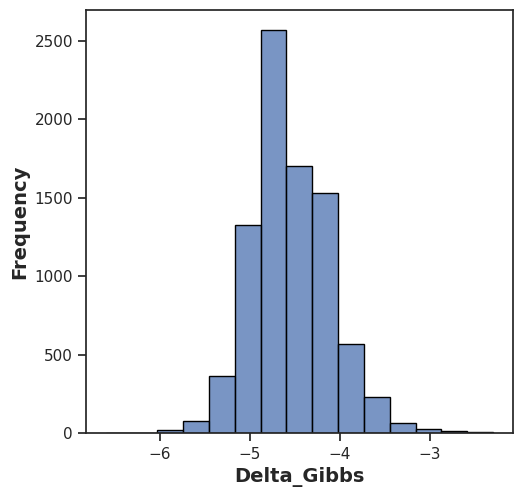

In [53]:
plt.figure(figsize=(5.5, 5.5))

sns.histplot(x='Delta_Gibbs', data=df, bins=15, edgecolor='black')

plt.xlabel('Delta_Gibbs', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# plt.savefig('plot_bioactivity_class.pdf')

**Delta Gibbs Box plot**


Text(0, 0.5, 'Delta_Gibbs')

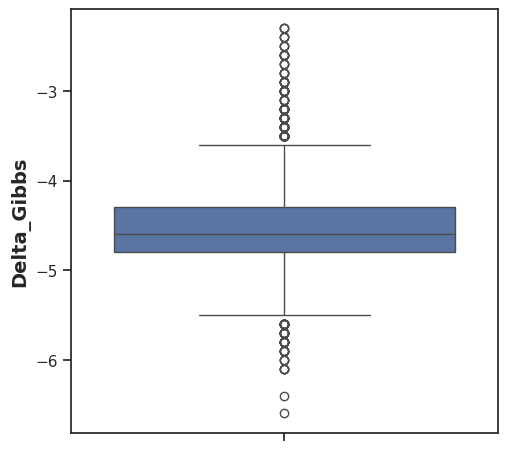

In [54]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(y='Delta_Gibbs', data=df)

plt.ylabel('Delta_Gibbs', fontsize=14, fontweight='bold')

**Descriptors Box Plot**

<Axes: >

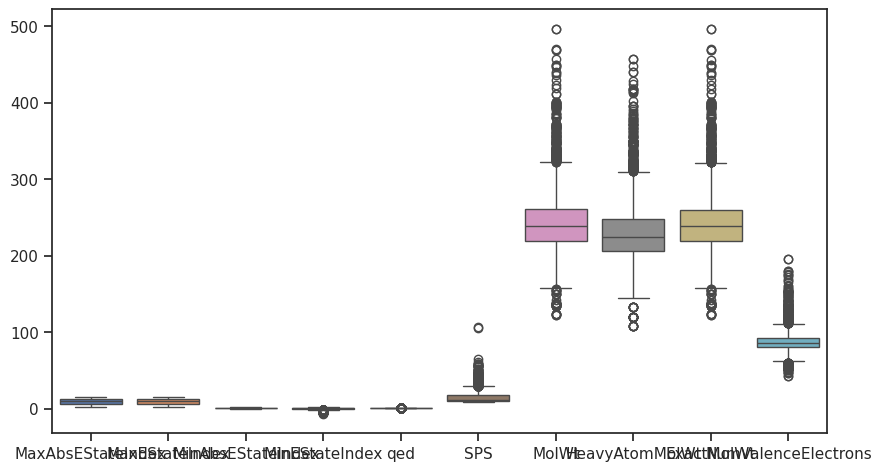

In [55]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_df.iloc[:,:10])

### Data Cleaning

In [65]:
RDKit_df.shape

(8515, 210)

In [66]:
# Drop columns with NaN
RDKit_df = RDKit_df.dropna(axis='columns')
RDKit_df.shape

(8515, 210)

In [68]:
# Drop columns with 90% zeros
RDKit_df = RDKit_df.loc[:, (RDKit_df == 0).mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 129)

### Data Transformation

In [45]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [46]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)

In [ ]:
# Create RDKit scaled DataFrame
RDKit = pd.DataFrame(RDKit_scaled)
RDKit.describe()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.50,0.50,0.32,0.81,0.66,0.07,0.32,0.35,0.32,0.28,...,0.07,0.03,0.09,0.51,0.04,0.02,0.07,0.09,0.06,0.03
std,0.28,0.28,0.24,0.15,0.13,0.07,0.09,0.10,0.09,0.08,...,0.12,0.08,0.15,0.20,0.09,0.07,0.12,0.13,0.14,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.27,0.12,0.77,0.57,0.02,0.26,0.28,0.26,0.25,...,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.63,0.63,0.25,0.83,0.68,0.03,0.31,0.33,0.31,0.29,...,0.00,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.76,0.76,0.49,0.91,0.75,0.10,0.37,0.40,0.37,0.32,...,0.20,0.00,0.20,0.67,0.00,0.00,0.20,0.11,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Merge descriptors dataframes with Delta Gibbs scores

In [37]:
RDKit = pd.concat([RDKit_df,df['Delta_Gibbs']], ignore_index=True, sort=False, axis = 1)
RDKit

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,12.40,12.40,0.41,-3.32,0.80,15.68,276.36,260.23,276.09,100,...,1,0,0,0,0,0,0,0,0,-4.20
1,11.68,11.68,0.30,-3.36,0.76,11.80,240.71,231.64,240.00,78,...,0,1,0,0,0,0,0,0,0,-4.20
2,12.34,12.34,0.35,-3.43,0.86,12.05,278.38,260.23,278.11,102,...,1,0,0,0,0,0,0,0,0,-4.20
3,11.03,11.03,0.04,-0.43,0.64,10.18,230.22,220.14,230.07,86,...,0,0,0,0,0,0,0,0,0,-4.50
4,12.29,12.29,0.19,-3.53,0.91,14.16,276.32,264.22,276.06,98,...,1,0,0,0,0,0,0,0,0,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,9.85,9.85,0.02,0.02,0.91,12.91,300.31,284.18,300.10,114,...,0,0,0,0,0,0,0,0,0,-4.90
8511,9.65,9.65,0.16,0.16,0.85,10.62,286.33,268.18,286.12,110,...,0,0,0,0,0,0,0,0,0,-4.70
8512,10.44,10.44,0.02,-0.02,0.76,11.95,300.31,284.18,300.10,114,...,0,0,0,0,0,0,0,0,0,-4.70
8513,10.27,10.27,0.04,0.04,0.71,12.10,270.28,256.17,270.09,102,...,0,0,0,0,0,0,0,0,0,-5.10


### Dimension Reduction Technique : PCA

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

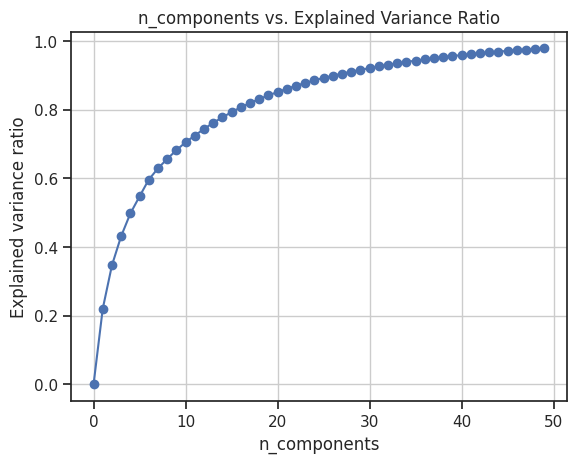

In [ ]:
nums = np.arange(50)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(RDKit)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.plot(nums,var_ratio,marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [ ]:
pca = PCA(n_components=50)
RDKit = pca.fit_transform(RDKit)

### Prepare the output/input dataframes

*   **Input:** PaDEL or RDKit descriptors
*   **Output:** pIC50 value

In [ ]:
# input = PaDEL.copy()
# output = pd.DataFrame(df2["pIC50"], columns=["pIC50"])
input = RDKit.copy()
output = pd.DataFrame(df["Delta_Gibbs"], columns=["Delta_Gibbs"])

In [ ]:
input_ = pd.DataFrame(input)
input_.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,...,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00
std,0.68,0.52,0.42,0.37,0.33,0.32,0.26,0.24,0.23,0.22,...,0.07,0.07,0.07,0.07,0.07,0.06,0.06,0.06,0.06,0.05
min,-1.49,-1.14,-1.06,-1.58,-1.35,-1.49,-0.89,-0.79,-1.21,-0.79,...,-0.48,-0.35,-0.41,-0.33,-0.39,-0.38,-0.45,-0.33,-0.42,-0.37
25%,-0.50,-0.37,-0.29,-0.20,-0.22,-0.18,-0.17,-0.16,-0.15,-0.15,...,-0.04,-0.04,-0.04,-0.04,-0.04,-0.03,-0.04,-0.04,-0.04,-0.03
50%,0.06,-0.13,-0.09,-0.01,0.00,0.03,-0.01,-0.00,-0.00,-0.01,...,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
75%,0.53,0.34,0.22,0.20,0.22,0.22,0.16,0.16,0.15,0.13,...,0.04,0.03,0.04,0.04,0.04,0.04,0.04,0.03,0.04,0.03
max,2.48,2.21,2.07,2.16,0.94,0.74,1.65,1.11,0.99,1.02,...,0.61,0.71,0.42,0.50,0.74,0.31,0.33,0.42,0.36,0.25


In [ ]:
# Split the data to training and testing
X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.30, random_state=3)

## Apply Machine Learning Algorithms

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

 98%|█████████▊| 41/42 [01:55<00:02,  2.57s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 50
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [01:56<00:00,  2.77s/it]


[(0.0, 1.0)]

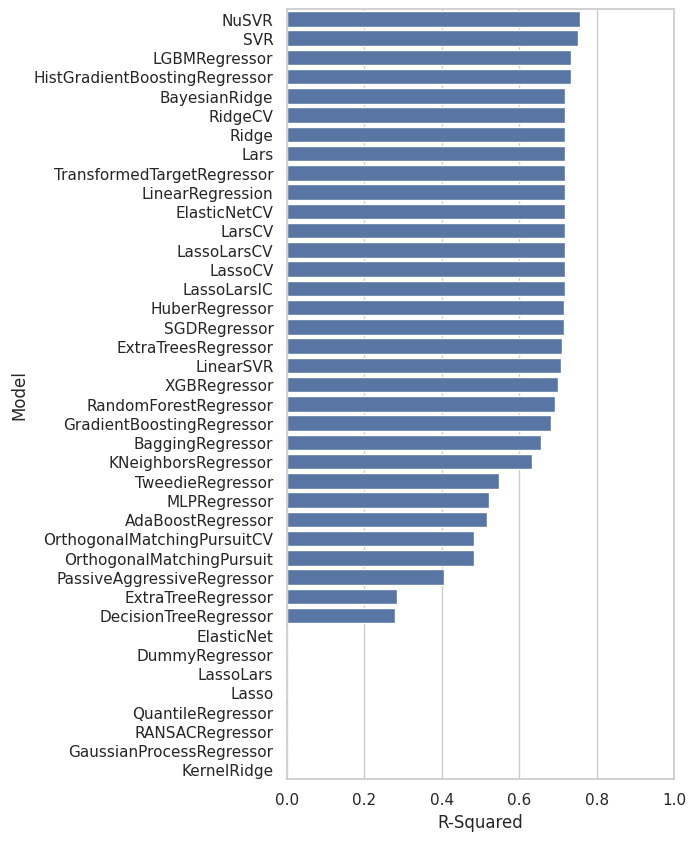

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="R-Squared", data=predictions)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

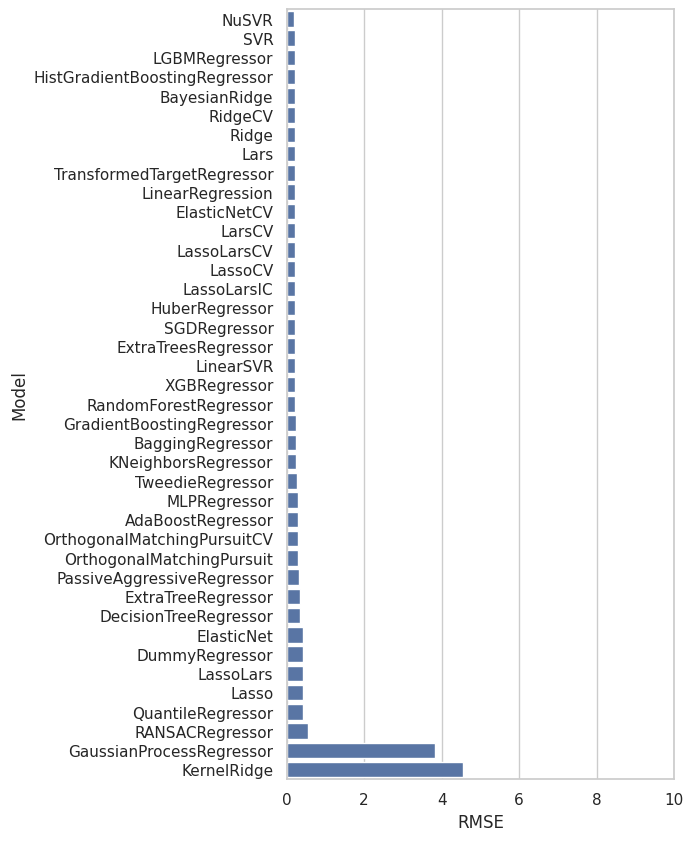

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="RMSE", data=predictions)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

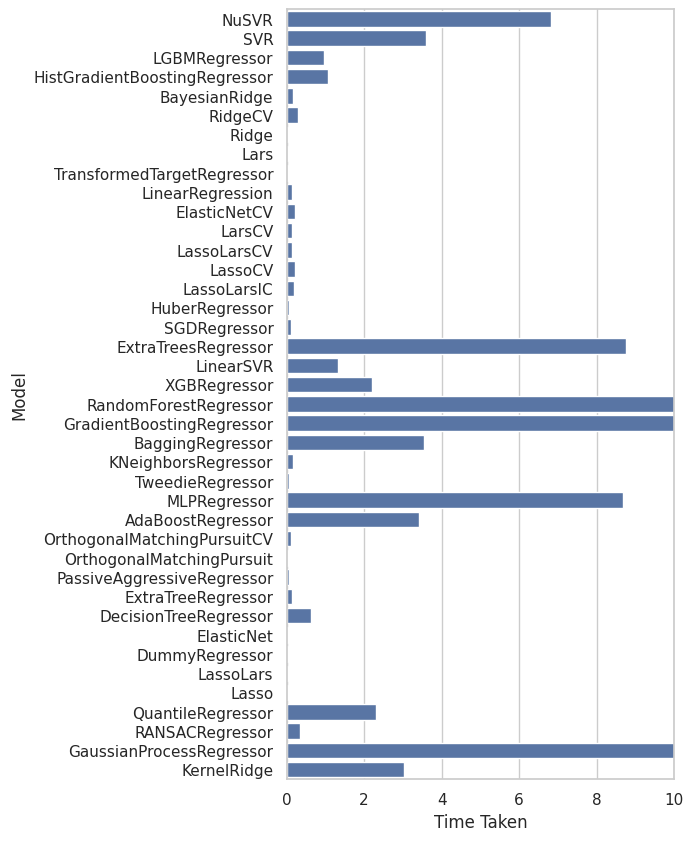

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="Time Taken", data=predictions)
ax.set(xlim=(0, 10))

In [ ]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
NuSVR                                        0.75       0.76  0.20        6.81
SVR                                          0.75       0.75  0.20        3.59
LGBMRegressor                                0.73       0.73  0.21        0.96
HistGradientBoostingRegressor                0.73       0.73  0.21        1.06
BayesianRidge                                0.71       0.72  0.22        0.17
RidgeCV                                      0.71       0.72  0.22        0.29
Ridge                                        0.71       0.72  0.22        0.05
Lars                                         0.71       0.72  0.22        0.05
TransformedTargetRegressor                   0.71       0.72  0.22        0.04
LinearRegression                             0.71       0.72  0.22        0.13
ElasticNetCV                                 0.71   

In [ ]:
# Regression models
models_ml = {
    "KernelRidge": KernelRidge(),
    "TransformedTargetRegressor": TransformedTargetRegressor(),
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "LassoLarsIC": LassoLarsIC(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "MLPRegressor": MLPRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "BaggingRegressor": BaggingRegressor(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    "LinearSVR": LinearSVR(),
    "SGDRegressor": SGDRegressor(),
    "LassoLarsCV": LassoLarsCV(),
    "LassoCV": LassoCV(),
    "LarsCV": LarsCV(),
    "ElasticNetCV": ElasticNetCV(),
    "Lasso": Lasso(),
    "LassoLars": Lasso(),
    "ElasticNet": ElasticNet(),
    "DummyRegressor": DummyRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "TweedieRegressor": TweedieRegressor(),
    "GammaRegressor": GammaRegressor(),
    "XGBRegressor": XGBRegressor(),
    "NuSVR": NuSVR(),
    "PoissonRegressor": PoissonRegressor(),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input, output, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                        -234.07 [-317.6  -193.22 -175.85 -200.07 -283.59]
    TransformedTargetRegressor                           0.64 [0.65 0.72 0.66 0.6  0.56]
              LinearRegression                           0.64 [0.65 0.72 0.66 0.6  0.56]
                          Lars                           0.64 [0.65 0.72 0.66 0.6  0.56]
                   LassoLarsIC                           0.64 [0.65 0.72 0.66 0.6  0.56]
      GaussianProcessRegressor                         -11.76 [ -3.12 -12.02  -7.99 -18.4  -17.26]
                  MLPRegressor                           0.69 [0.79 0.75 0.72 0.64 0.53]
               RANSACRegressor                          -0.82 [-1.81 -0.42 -0.38  0.28 -1.76]
    PassiveAggressiveRegressor                           0.09 [ 0.22 -0.15 -0.2   0.27  0.31]
         DecisionTreeRegressor                           0.16 [0.24 0.27 0.15 0.06 0.06]
     Gradient